## Background

The goal of the MLapp project is to provide the following:

1. Illustrate how to build machine learning powered developer tools using the [GitHub Api](https://developer.github.com/v3/) and Flask.  We would like to show data scientists how to build exciting data products using machine learning on the GitHub marketplace, that developers can use.  Specifically, we will build an illustrative data product that will automatically label issues.  

2. Gather feedback and iterate 


The scope of this notebook is to addresses part of goal #1, by illustrating how we can acquire a dataset of GitHub issue labels and train a classifier.  

The top issues on GitHub by count are illustrated in [this spreadsheet](https://docs.google.com/spreadsheets/d/1NPacnVsyZMBneeewvPGhCx512A1RPYf8ktDN_RpKeS4/edit?usp=sharing).  To keep things simple, we will build a model to classify an issue as a `bug`, `feature` or `question`.  We use hueristics to collapse a set of issue labels into these three categories, which can be viewed [in this query](https://console.cloud.google.com/bigquery?sq=123474043329:01abf8866144486f932c756730ddaff1).  

The heueristic for these class labels are contained within the below case statement:

```{sql}
  CASE when labels like '%bug%' and labels not like '%not bug%' then True else False end as Bug_Flag,
  CASE when labels like '%feature%' or labels like '%enhancement%' or labels like '%improvement%' or labels like '%request%' then True else False end as Feature_Flag,
  CASE when labels like '%question%' or labels like '%discussion%' then True else False end as Question_Flag,
```
    the above case statement is located within [this query](https://console.cloud.google.com/bigquery?sq=123474043329:01abf8866144486f932c756730ddaff1)
    

The following alternative projects were tried before this task that we did not pursue further:
 - Transfer learning using the [GitHub Issue Summarizer](https://github.com/hamelsmu/Seq2Seq_Tutorial) to enable the prediction of custom labels on existing repos.  Found that this did not work well as there is a considerable amount of noise with regards to custom labels in repositories and often not enough data to adequately predict this.  
 - Tried to classify more than the above three classes, however the human-labeled issues are very subjective and it is not clear what is a question vs. a bug.  
 - Tried multi-label classification since labels can co-occur.  There is very little overlap between `bug`, `feature` and `question` labels, so we decided to simplify things and make this a multi-class classificaiton problem instead.  


Note: the code in this notebook was executed on a [p3.8xlarge](https://aws.amazon.com/ec2/instance-types/p3/) instance on AWS.

## Outline 

This notebook will follow these steps:

1. Download and partition dataset
2. Pre-process dataset
2. Build model architecture & Train Model
3. Evaluate Model


# Download and Partition Dataset

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

pd.set_option('max_colwidth', 1000)

In [10]:
df = pd.concat([pd.read_csv(f'https://storage.googleapis.com/codenet/issue_labels/00000000000{i}.csv.gz')
                for i in range(10)])

#split data into train/test
traindf, testdf = train_test_split(df, test_size=.15)

traindf.to_pickle('traindf.pkl')
testdf.to_pickle('testdf.pkl')

#print out stats about shape of data
print(f'Train: {traindf.shape[0]:,} rows {traindf.shape[1]:,} columns')
print(f'Test: {testdf.shape[0]:,} rows {testdf.shape[1]:,} columns')

Train: 2,698,578 rows 10 columns
Test: 476,220 rows 10 columns


### Discussion of the data

In [7]:
# preview data
traindf.head(3)

,url,repo,title,body,num_labels,labels,c_bug,c_feature,c_question,class_int
112473,"""https://github.com/DockStation/dockstation/issues/6""",DockStation/dockstation,feature request: image layers window hide,"some feedback for this window:\r \r ! image https://cloud.githubusercontent.com/assets/9369080/25952392/3769f842-3669-11e7-8a91-4ed2de640246.png \r \r \r it's really cool, but blocking. i think users would prefer to be able hide it the \ ok\ was not hiding it in my case - don't know if it should?",2,"[""enhancement"", ""wish""]",False,True,False,1
33329,"""https://github.com/julianschritt/secreth_telegrambot/issues/2""",julianschritt/secreth_telegrambot,grant group admins permissions to /cancelgame and /startgame,ending a game requires the person who started it to end it. even kicking and re-adding the bot doesn't close an existing game. so if the person who started a game is afk for a long time the bot becomes useless for that group.,1,"[""enhancement"", ""enhancement""]",False,True,False,1
95978,"""https://github.com/remotestorage/remotestorage-bookmarks-chrome/issues/3""",remotestorage/remotestorage-bookmarks-chrome,deprecate in favor of memm?,"this thing is super old and nobody's actively maintaining it. i don't know if someone's actively using it, but i think it would make sense to direct people coming here to https://github.com/lesion/memm, which works and is maintained by @lesion, who's also a core contributor to rs.js.",1,"[""question""]",False,False,True,2


Discussion of the data:  

- url:        url where you can find this issue
- repo:       owner/repo name
- title:      title of the issue
- body:       body of the issue, not including comments
- num_labels: number of issue labels
- labels:     an array of labels applied a user manually applied to the issue (represented as a string)
- c_bug:      boolean flag that indicates if the issue label corresponds to a bug
- c_feature:  boolean flag that indicates if the issue label corresponds to a feature
- c_question: boolean flag that indicates if the issue label corresponds to a question
- class_int:  integer between 0 - 2 that corresponds to the class label.  **0=bug, 1=feature, 2=question**

### Summary Statistics

Class frequency **0=bug, 1=feature, 2=question**

In [14]:
traindf.groupby('class_int').size()

class_int
0    1211335
1    1231499
2     255744
dtype: int64

number of unique repos

In [28]:
print(f' Avg # of issues per repo: {len(traindf) / traindf.repo.nunique():.1f}')
print(f" Avg # of issues per org: {len(traindf) / traindf.repo.apply(lambda x: x.split('/')[-1]).nunique():.1f}")

 Avg # of issues per repo: 7.6
 Avg # of issues per org: 8.7


Most popular repos by # of issues:

 - `pcnt` = percent of total issues in the dataset
 - `count` = number of issues in the dataset for that repo

In [38]:
pareto_df = pd.DataFrame({'pcnt': df.groupby('repo').size() / len(df), 'count': df.groupby('repo').size()})
pareto_df.sort_values('pcnt', ascending=False).head(20)

,pcnt,count
repo,,
Microsoft/vscode,0.005128,16281
rancher/rancher,0.002450,7779
MicrosoftDocs/azure-docs,0.001963,6233
godotengine/godot,0.001952,6198
ansible/ansible,0.001950,6192
hashicorp/terraform,0.001649,5235
kubernetes/kubernetes,0.001621,5147
lionheart/openradar-mirror,0.001330,4221
elastic/kibana,0.001201,3813


# Pre-Process Data

To process the raw text data, we will use [ktext](https://github.com/hamelsmu/ktext)

In [50]:
from ktext.preprocess import processor
import dill as dpickle
import numpy as np

Clean, tokenize, and apply padding / truncating such that each document length = 75th percentile for the dataset.
Retain only the top keep_n words in the vocabulary and set the remaining words to 1 which will become common index for rare words.

**Warning:** the below block of code can take a long time to execute.

#### Learn the vocabulary from the training dataset

In [40]:
%%time

train_body_raw = traindf.body.tolist()
train_title_raw = traindf.title.tolist()

# Clean, tokenize, and apply padding / truncating such that each document length = 75th percentile for the dataset.
#  also, retain only the top keep_n words in the vocabulary and set the remaining words
#  to 1 which will become common index for rare words 

# process the issue body data
body_pp = processor(heuristic_pct_padding=.75, keep_n=8000)
train_body_vecs = body_pp.fit_transform(train_body_raw)

# process the title data
title_pp = processor(heuristic_pct_padding=.75, keep_n=4500)
train_title_vecs = title_pp.fit_transform(train_title_raw)

 See full histogram by insepecting the `document_length_stats` attribute.
 See full histogram by insepecting the `document_length_stats` attribute.


CPU times: user 8min 8s, sys: 32.3 s, total: 8min 40s
Wall time: 20min 24s


#### Apply transformations to Test Data

In [41]:
%%time

test_body_raw = testdf.body.tolist()
test_title_raw = testdf.title.tolist()

test_body_vecs = body_pp.transform_parallel(test_body_raw)
test_title_vecs = title_pp.transform_parallel(test_title_raw)

CPU times: user 57.5 s, sys: 31 s, total: 1min 28s
Wall time: 4min 16s


#### Extract Labels

Add an additional dimension to the end to facilitate compatibility with Keras.

In [53]:
train_labels = np.expand_dims(traindf.class_int.values, -1)
test_labels = np.expand_dims(testdf.class_int.values, -1)

#### Check shapes

In [64]:
# the number of rows in data for the body, title and labels should be the same for both train and test partitions
assert train_body_vecs.shape[0] == train_title_vecs.shape[0] == train_labels.shape[0]
assert test_body_vecs.shape[0] == test_title_vecs.shape[0] == test_labels.shape[0]

#### Save pre-processors and data to disk

In [55]:
# Save the preprocessor
with open('body_pp.dpkl', 'wb') as f:
    dpickle.dump(body_pp, f)

with open('title_pp.dpkl', 'wb') as f:
    dpickle.dump(title_pp, f)

# Save the processed data
np.save('train_title_vecs.npy', train_title_vecs)
np.save('train_body_vecs.npy', train_body_vecs)
np.save('test_body_vecs.npy', test_body_vecs)
np.save('test_title_vecs.npy', test_title_vecs)
np.save('train_labels.npy', train_labels)
np.save('test_labels.npy', test_labels)

# Build Architecture & Train Model

In [8]:
import tensorflow as tf
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
import numpy as np
import dill as dpickle

In [9]:
print(tf.__version__)

1.12.0


Load the data and shape information

In [3]:
with open('title_pp.dpkl', 'rb') as f:
    title_pp = dpickle.load(f)

with open('body_pp.dpkl', 'rb') as f:
    body_pp = dpickle.load(f)
    
#load the training data and labels
train_body_vecs = np.load('train_body_vecs.npy')
train_title_vecs = np.load('train_title_vecs.npy')
train_labels = np.load('train_labels.npy')

#load the test data and labels
test_body_vecs = np.load('test_body_vecs.npy')
test_title_vecs = np.load('test_title_vecs.npy')
test_labels = np.load('test_labels.npy')


issue_body_doc_length = train_body_vecs.shape[1]
issue_title_doc_length = train_title_vecs.shape[1]

body_vocab_size = body_pp.n_tokens
title_vocab_size = title_pp.n_tokens

num_classes = len(set(train_labels[:, 0]))
assert num_classes == 3

Using TensorFlow backend.


#### Build Model Architecture

We did very little hyperparameter tuning.  Keeping model simple as possible.

In [27]:
body_input = Input(shape=(issue_body_doc_length,), name='Body-Input')
title_input = Input(shape=(issue_title_doc_length,), name='Title-Input')

body = Embedding(body_vocab_size, 50, name='Body-Embedding')(body_input)
title = Embedding(title_vocab_size, 50, name='Title-Embedding')(title_input)

body = BatchNormalization()(body)
body = GRU(100, name='Body-Encoder')(body)

title = BatchNormalization()(title)
title = GRU(75, name='Title-Encoder')(title)

x = Concatenate(name='Concat')([body, title])
x = BatchNormalization()(x)
out = Dense(num_classes, activation='softmax')(x)

model = Model([body_input, title_input], out)

model.compile(optimizer=Adam(lr=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Body-Input (InputLayer)         (None, 105)          0                                            
__________________________________________________________________________________________________
Title-Input (InputLayer)        (None, 10)           0                                            
__________________________________________________________________________________________________
Body-Embedding (Embedding)      (None, 105, 50)      400050      Body-Input[0][0]                 
__________________________________________________________________________________________________
Title-Embedding (Embedding)     (None, 10, 50)       225050      Title-Input[0][0]                
__________________________________________________________________________________________________
batch_norm

#### Train Model

In [29]:
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

script_name_base = 'Issue_Label_v1'
csv_logger = CSVLogger('{:}.log'.format(script_name_base))
model_checkpoint = ModelCheckpoint('{:}_best_model.hdf5'.format(script_name_base),
                                   save_best_only=True)

In [30]:
batch_size = 900
epochs = 4
history = model.fit(x=[train_body_vecs, train_title_vecs], 
                    y=train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=[(test_body_vecs, test_title_vecs), test_labels], 
                    callbacks=[csv_logger, model_checkpoint])

Train on 2698578 samples, validate on 476220 samples
Epoch 1/4
2698578/2698578 [==============================] - 603s 223us/step - loss: 0.5008 - acc: 0.8086 - val_loss: 0.4699 - val_acc: 0.8209
Epoch 2/4
2698578/2698578 [==============================] - 599s 222us/step - loss: 0.4558 - acc: 0.8265 - val_loss: 0.4611 - val_acc: 0.8248
Epoch 3/4
2698578/2698578 [==============================] - 598s 221us/step - loss: 0.4380 - acc: 0.8332 - val_loss: 0.4593 - val_acc: 0.8250
Epoch 4/4
2698578/2698578 [==============================] - 597s 221us/step - loss: 0.4230 - acc: 0.8393 - val_loss: 0.4616 - val_acc: 0.8243


# Evaluate Model

Compute a confusion matrix

In [37]:
from tensorflow.keras.models import load_model
from utils import plot_confusion_matrix


#load the test data and labels
test_body_vecs = np.load('test_body_vecs.npy')
test_title_vecs = np.load('test_title_vecs.npy')
test_labels = np.load('test_labels.npy')

#load the best model
best_model = load_model('Issue_Label_v1_best_model.hdf5')

#get predictions
y_pred = np.argmax(best_model.predict(x=[test_body_vecs, test_title_vecs],
                                      batch_size=15000),
                   axis=1)

# get labels
y_test = test_labels[:, 0]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Normalized confusion matrix
[[0.88173203 0.09765211 0.02061586]
 [0.1303451  0.83997974 0.02967516]
 [0.27873486 0.23896011 0.48230502]]


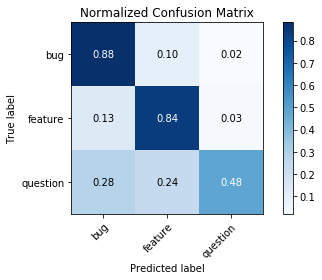

In [39]:
plot_confusion_matrix(y_test, 
                      y_pred, 
                      classes=np.array(['bug', 'feature', 'question']), 
                      normalize=True, 
                      title='Normalized Confusion Matrix')

# Make Predictions

In [5]:
from utils import IssueLabeler
from tensorflow.keras.models import load_model
import dill as dpickle

In [6]:
#load the best model
best_model = load_model('Issue_Label_v1_best_model.hdf5')

#load the pre-processors
with open('title_pp.dpkl', 'rb') as f:
    title_pp = dpickle.load(f)

with open('body_pp.dpkl', 'rb') as f:
    body_pp = dpickle.load(f)
    
# instantiate the IssueLabeler object
issue_labeler = IssueLabeler(body_text_preprocessor=body_pp,
                             title_text_preprocessor=title_pp,
                             model=best_model)    

Using TensorFlow backend.


In [9]:
issue_labeler.get_probabilities(body='Can someone please help me?', 
                                title='random stuff')

{'bug': 0.12618249654769897,
 'feature': 0.1929263472557068,
 'question': 0.6808911561965942}

In [10]:
issue_labeler.get_probabilities(body='It would be great to add a new button', 
                                title='requesting a button')

{'bug': 0.019261939451098442,
 'feature': 0.9305700659751892,
 'question': 0.05016808584332466}

In [11]:
issue_labeler.get_probabilities(body='It does` not work, I get bad errors', 
                                title='nothing works')

{'bug': 0.9065071940422058,
 'feature': 0.03202613815665245,
 'question': 0.06146678701043129}